In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import *

In [2]:
behavestring = '/Volumes/Voss_Lab/EEG/domcueMIXED_djb/behave.data/'
behavepath=Path(behavestring)
def get_subids(behavepath):
    subfiles="*study"
    sublist = []
    for filepathobj in behavepath.glob(subfiles):
        fname=filepathobj.name
        sub = fname[:3]
        sublist.append(sub)
    sublist.sort()
    return sublist
subids = get_subids(behavepath)
subids = ['301']
sub = '301'

In [3]:
def set_behavior_path(sub, behavestring):
    extra='study'
    behaveobj=[behavestring+sub+extra]
    behavefilepath=Path(behaveobj[0])
    behavefilepath.exists()
    return behavefilepath

def read_behave_file(filepath):
    """read in behavearray, turn into DataFrame and delete extra columns"""
    colnames=['obj1','obj2','obj3','cuecond','loc1','x1','y1','loc2','x2','y2','loc3','x3','y3',
     'domRT','dom_resp','cond','block','tmp', 'tmp']
    behavearray=pd.read_table(filepath,header=None,names=colnames)
    tmpmask=~behavearray.columns.str.contains('tmp')
    behavearray=behavearray[behavearray.columns[tmpmask]]
    trialnum = np.arange(1,len(behavearray)+1)
    behavearray['studytrial'] = trialnum
    return behavearray


behavefilepath = set_behavior_path(sub, behavestring)
behavearray = read_behave_file(behavefilepath)
behavearray

/Users/drdj/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/io/parsers.py:709: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


,obj1,obj2,obj3,cuecond,loc1,x1,y1,loc2,x2,y2,loc3,x3,y3,domRT,dom_resp,cond,block,studytrial
0,111,140,61,1,7,-140,330,10,140,330,9,-140,-110,143,7,1,1,1
1,53,209,101,1,11,140,110,10,140,330,13,420,330,119,11,1,1,2
2,157,74,25,2,4,-420,330,16,700,330,10,140,330,134,4,1,1,3
3,177,135,38,1,17,700,110,15,420,-110,2,-700,110,96,17,1,1,4
4,41,236,195,1,5,-420,110,9,-140,-110,3,-700,-110,350,5,1,1,5
5,2,142,200,1,1,-700,330,4,-420,330,16,700,330,159,1,1,1,6
6,126,78,203,1,12,140,-110,15,420,-110,13,420,330,83,12,1,1,7
7,52,176,32,2,14,420,110,5,-420,110,15,420,-110,95,14,1,1,8
8,202,105,166,1,1,-700,330,2,-700,110,10,140,330,168,1,1,1,9
9,132,153,136,2,1,-700,330,3,-700,-110,9,-140,-110,230,1,1,1,10


In [4]:
def adjust_pres_coords(array,x,y,xmax=1920/2,ymax=1080/2):
    """adjustment for behavioral coords to match
    eye coords for presentation version of exp"""
    newarray=pd.DataFrame()
    newarray[x]=array[x]+xmax
    newarray[y]=(array[y]-ymax)*-1
    return newarray

def apply_adjust_pres_coords(behavearray):
    """applies adjust_pres_coords to all
    coords in behave array"""
    
    xs = [f'x{loc}' for loc in range(1,4)]
    ys = [f'y{loc}' for loc in range(1,4)]

    newlocs = pd.DataFrame()
    for loc in zip(xs, ys):
        x = loc[0]
        y = loc[1]
        newloc=adjust_pres_coords(behavearray,x,y)
        newlocs[x] = newloc[x]
        newlocs[y] = newloc[y]

    cols=newlocs.columns.tolist()
    for loc in cols:
        behavearray[loc]=newlocs[loc]
    return behavearray

behavearray = apply_adjust_pres_coords(behavearray)
behavearray

,obj1,obj2,obj3,cuecond,loc1,x1,y1,loc2,x2,y2,loc3,x3,y3,domRT,dom_resp,cond,block,studytrial
0,111,140,61,1,7,820.0,210.0,10,1100.0,210.0,9,820.0,650.0,143,7,1,1,1
1,53,209,101,1,11,1100.0,430.0,10,1100.0,210.0,13,1380.0,210.0,119,11,1,1,2
2,157,74,25,2,4,540.0,210.0,16,1660.0,210.0,10,1100.0,210.0,134,4,1,1,3
3,177,135,38,1,17,1660.0,430.0,15,1380.0,650.0,2,260.0,430.0,96,17,1,1,4
4,41,236,195,1,5,540.0,430.0,9,820.0,650.0,3,260.0,650.0,350,5,1,1,5
5,2,142,200,1,1,260.0,210.0,4,540.0,210.0,16,1660.0,210.0,159,1,1,1,6
6,126,78,203,1,12,1100.0,650.0,15,1380.0,650.0,13,1380.0,210.0,83,12,1,1,7
7,52,176,32,2,14,1380.0,430.0,5,540.0,430.0,15,1380.0,650.0,95,14,1,1,8
8,202,105,166,1,1,260.0,210.0,2,260.0,430.0,10,1100.0,210.0,168,1,1,1,9
9,132,153,136,2,1,260.0,210.0,3,260.0,650.0,9,820.0,650.0,230,1,1,1,10


In [5]:
eyestring = '/Volumes/Voss_Lab/EEG/domcueMIXED_djb/eye.data/'
eyepath=Path(eyestring)
def parse_eye_filename(pathobject):
    fname=pathobject.name
    parts=fname.split(".")[0]
    subject=parts[:3]
    block=parts[3:4]
    subdict={"subject":subject, "block":block, "fname":fname}
    return subdict

def get_eye_files(subids,eyepath):
    """ returns master dataframe including eye file name, block, phase, subid
    input list of subject strings, Path object pointing to eye files
    """
    substrings=[s+"*.asc" for s in subids]
    subinfo=[]
    for s in substrings:
        for filepathobj in eyepath.glob(s):
            subdict=parse_eye_filename(filepathobj)
            subinfo.append(subdict)

    masterdf=pd.DataFrame(subinfo).sort_values(by=["subject","block"])
    print(masterdf.head())
    masterdf=masterdf[["subject","block","fname"]]
    masterdf.index=range(len(masterdf))
    return masterdf

masterdf = get_eye_files(subids,eyepath)
eye_sub = masterdf[masterdf['subject']==sub]
eye_sub

  block     fname subject
0     1  3011.asc     301
4     2  3012.asc     301
5     3  3013.asc     301
1     4  3014.asc     301
2     5  3015.asc     301


,subject,block,fname
0,301,1,3011.asc
1,301,2,3012.asc
2,301,3,3013.asc
3,301,4,3014.asc
4,301,5,3015.asc
5,301,6,3016.asc
6,301,7,3017.asc
7,301,8,3018.asc


In [6]:
def parse_eye_events_to_intline(line,extrainfo):
    efixspace=["","",""]
    eblinkspace=efixspace*2
    newline=line.split()
    if "EFIX" in line:
        newline.extend(efixspace)
    elif "EBLINK" in line:
        newline.extend(eblinkspace)
    newline.extend(extrainfo)
    return newline

def parse_eye_line(eye_sub, eyestring):
    """ parses each line of eye file for a given eye_phase_sub
    input one phase type list of files for a subs
    and the path to the file (in form of a string)
    outputs dataframe with all events in table
    """
    etypes=('ESACC','EFIX','EBLINK')
    study=[]
    restudy=[]
    all_start_lines = []
    blocks=eye_sub.block
    fnames=eye_sub.fname
    subjects=eye_sub.subject
    totalcount=0
    trialnum=0
    print(eyestring)
    for block,fname,subject in zip(blocks,fnames,subjects):
        path_file=eyestring+fname
        startcount=0
        p=Path(path_file)
        with p.open() as f:
            for line in f:
                if "START" in line:
                    totalcount=totalcount+1
                    startline=line.split()
                    all_start_lines.append(startline)
                    starttime=int(startline[1])
                    if totalcount % 2:
                        trialnum = trialnum+1

                if any(e in line for e in etypes):
                    extrainfo=[starttime,trialnum,block,subject]
                    newline=parse_eye_events_to_intline(line,extrainfo)
                    if totalcount % 2:
                        study.append(newline)
                    else:
                        restudy.append(newline)

            print(trialnum, block, startcount)
    return study, restudy, all_start_lines
study, restudy, all_start_lines = parse_eye_line(eye_sub, eyestring)

/Volumes/Voss_Lab/EEG/domcueMIXED_djb/eye.data/
20 1 0
40 2 0
60 3 0
80 4 0
100 5 0
120 6 0
140 7 0
160 8 0


In [7]:
def events_to_df(events):
    """ change raw events to data DataFrame
    then and change values to numeric"""

    eye_events_df=pd.DataFrame(events)
    eye_events_df=eye_events_df.apply(pd.to_numeric,errors='ignore')
    headers=["event","eye","start","end","duration",
    "xstart","ystart","xend","yend","?","?","trialstart",
    "trialnum","block","sub"]
    eye_events_df.columns=headers
    return eye_events_df

def eventsdf_cleanup(eye_events_df):
    x=pd.DataFrame()
    """adjust trial start time, remove irrelevant values in fixation rows,
    and then delete excess columns"""

    eyedf_clean=eye_events_df.copy()

    eyedf_clean['start']=eyedf_clean['start']-eyedf_clean['trialstart']
    eyedf_clean['end']=eyedf_clean['end']-eyedf_clean['trialstart']

    efix_mask = (eyedf_clean["event"]=="EFIX")
    eyedf_clean.loc[efix_mask, 'xend'] = np.nan
    for col in ['xstart', 'ystart', 'xend', 'yend']:
        x = eyedf_clean[col]
        eyedf_clean[col] = pd.to_numeric(x, errors='coerce')
        
            
#     del eyedf_clean['trialstart']
    del eyedf_clean['?']
    del eyedf_clean['eye']

    return eyedf_clean

studydf = events_to_df(study)
studyeyearray = eventsdf_cleanup(studydf)

restudydf = events_to_df(restudy)
restudeyearray = eventsdf_cleanup(restudydf)

In [9]:
studyeyearray['phase']='study'
restudeyearray['phase']='restudy'
eyearray = pd.concat([studyeyearray, restudeyearray], ignore_index=True)

In [10]:
def eye_behave_combo(eyearray,behavearray):
    eyebehave=eyearray.copy()
    eyecols=eyebehave.columns.tolist()
    behavecols=['x1','y1','x2','y2','x3','y3','cond', 'loc1', 'dom_resp', 'studytrial']
    allcols=eyecols+behavecols
    eyebehave=eyebehave.reindex(columns=allcols)
    order_col='studytrial'
    behavearray.sort_values(by=[order_col], inplace=True)
    behavearray.set_index(order_col, drop=False, inplace=True)
    for trial in range(0,behavearray.shape[0]):
        eyetrialevents=(eyebehave['trialnum']==trial+1)
        eyetrial=eyebehave.loc[eyetrialevents]
        for col in behavecols:
            eyetrial.loc[eyetrialevents,col]=behavearray.loc[trial+1,col]

        eyebehave.loc[eyetrialevents]=eyetrial
    return eyebehave

eyebehave = eye_behave_combo(eyearray, behavearray)


/Users/drdj/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
def dist(array,x1,y1,x2,y2):
    """ distance formula for columns of coords"""
    dx=array[x1]-array[x2]
    dy=array[y1]-array[y2]
    dist=np.sqrt(dx**2+dy**2)
    return dist

def calculate_dist(eyebehave,x1,y1,name):
    """ calculate distances for start and end eye locations"""
    for x in eyebehave:
        distdict={'obj1':dist(eyebehave,x1,y1,'x1','y1'),
                        'obj2':dist(eyebehave,x1,y1,'x2','y2'),
                        'obj3':dist(eyebehave,x1,y1,'x3','y3')}

    distarray=pd.DataFrame(distdict)
    col=distarray.columns.tolist()
    distarray.columns=[c+name for c in col]
    return distarray


def loc_view(eyebehave,distarray,name):
    distarray.idxmin(axis=1)
    mindistmask=distarray.min(axis=1)<180
    distmins=distarray.loc[mindistmask]

    distminlocs=distmins.idxmin(axis=1)
    eyebehave[name]="none"
    eyebehave.loc[mindistmask,name]=distminlocs
    return eyebehave

def screenview(x,y,xmax=1920,ymax=1080):
    screen='screen'
    if x>xmax:
        screen='offscreen'
    if x<(0):
        screen='offscreen'
    if y>ymax:
        screen='offscreen'
    if y<(0):
        screen='offscreen'
    return screen

def assign_screenview(eyebehavedict,xname,yname,name):
    colname=name+'loc'
    for loc in eyebehavedict:
        screen=screenview(loc[xname],loc[yname])
        if loc[colname]=='none':
            loc[colname]=screen
        if name !='end':
            continue
        if loc['event']=='EFIX':
            loc[colname]=np.nan
    return eyebehavedict


def adjust_fix_before_blink(eyebehavedict):
    """replace fixations <100 ms before blinks"""
    tmp_dict=eyebehavedict.copy()
    new_previous_events=[]
    for i,ind in enumerate(tmp_dict):
        current_event = ind
        if i>0:
            if current_event['event']=='EBLINK':
                if previous_event['trialnum']==current_event['trialnum']:
                    if previous_event['event']=='EFIX' and previous_event['duration']<100:
                        previous_event['event']='blink'
            new_previous_events.append(previous_event)
        previous_event=ind
    new_previous_events.append(previous_event)
    return new_previous_events

def adjust_event_after_blink(new_previous_events):
    new_post_events=[]
    new_events=new_previous_events.copy()
    flag=False
    for current_event in new_events:
        event_type=current_event['event']
        current_trial=current_event['trialnum']
        if flag==True and previous_trial==current_trial:
            if event_type=='ESACC':
                event_type='blink'
            elif event_type=='EFIX':
                if current_event['duration']<100:
                    event_type='blink'
        new_post_events.append(current_event)
        flag=(event_type=='EBLINK')
        previous_trial=current_trial
    return new_post_events

def eyedict_backto_df(new_post_events):
    corrected_eyedf=pd.DataFrame(new_post_events)
    old_blink_mask=corrected_eyedf['event']!='EBLINK'
    corrected_eyedf=corrected_eyedf[old_blink_mask]
    corrected_eyedf.sort_values(['block','trialnum','start'])
    corrected_eyedf=corrected_eyedf.reset_index(drop=True)
    return corrected_eyedf

In [12]:
# calculate distances for start and end eye locations
startdistarray=calculate_dist(eyebehave,x1='xstart',y1='ystart',name='start')
enddistarray=calculate_dist(eyebehave,'xend','yend','end')

# start & end locations
eyebehave=loc_view(eyebehave,startdistarray,'startloc')
eyebehave=loc_view(eyebehave,enddistarray,'endloc')

#append start & end distances to eyebehave array
eyebehave=pd.concat([eyebehave, startdistarray, enddistarray], axis=1)

''' change df to dict'''
eyebehavedict=eyebehave.to_dict('records')
''' determine if non-loc viewing was on screen or offscreen'''
eyebehavedict=assign_screenview(eyebehavedict,'xstart','ystart','start')
eyebehavedict=assign_screenview(eyebehavedict,'xend','yend','end')

'''adjust artifacts in eye data due to blinks'''
new_previous_events=adjust_fix_before_blink(eyebehavedict)
corrected_eye_events=adjust_event_after_blink(new_previous_events)

'''put data back in df and remove old blinks'''
subcleandf=eyedict_backto_df(corrected_eye_events)

In [13]:
# fname='data/'+sub+'eyebehave.csv'
# subcleandf.to_csv(fname)

In [14]:
subcleandf.cond.unique()

array([1., 2.])

In [6]:
subcleandf = pd.read_csv('data/402eyebehave.csv')

In [7]:
def make_timeseries(subcleandf, condnum):
    studytimearray = pd.DataFrame(index=range(4500), columns=range(0,161))
    restudytimearray = pd.DataFrame(index=range(4500), columns=range(0,161))
    fix = subcleandf[(subcleandf['event']=='EFIX') & (subcleandf['cond']==condnum)]
    offmask = (fix['startloc'] == 'offscreen')
    fix.loc[offmask, 'startloc'] = np.nan
    trialcount = 0
    for groups, ldf in fix.groupby(by=['trialnum', 'phase']):
        trial, phase = groups
        for item, trialinfo in ldf.iterrows():
            start = trialinfo['start']
            end = trialinfo['end']
            loc = trialinfo['startloc']
            if phase == 'study':
                studytimearray.iloc[start:end, trial] = loc
            elif phase == 'restudy':
                restudytimearray.iloc[start:end, trial] = loc
    studytimearray.dropna(axis=1, how='all', inplace = True)  
    restudytimearray.dropna(axis=1, how='all', inplace = True)
    return studytimearray, restudytimearray
actstudytimearray, actrestudytimearray = make_timeseries(subcleandf, 1)
passtudytimearray, pasrestudytimearray = make_timeseries(subcleandf, 2)

/Users/drdj/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
def get_timeseries_props(timearray):
    numtrials = timearray.shape[1]
    props = pd.DataFrame(index=range(timearray.shape[0]))

    alltot = timearray.count(axis=1)
    props['total_fix'] = alltot

    objlist = ['obj1start', 'obj2start', 'obj3start', 'screen']
    
    for loc in objlist:
        objset = timearray[timearray==loc].count(axis=1)
        props[loc] = objset/alltot
    
    props.reset_index(inplace=True)
    props.rename(columns={'index':'time'}, inplace=True)    
    
    return props

actstudyprops = get_timeseries_props(actstudytimearray)
actrestudyprops = get_timeseries_props(actrestudytimearray)

passtudyprops = get_timeseries_props(passtudytimearray)
pasrestudyprops = get_timeseries_props(pasrestudytimearray)

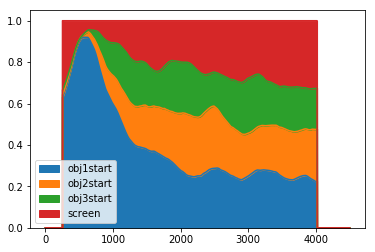

In [19]:
objlist = ['obj1start', 'obj2start', 'obj3start', 'screen']
b = actrestudyprops.rolling(window=250).mean()
b[objlist].plot.area()

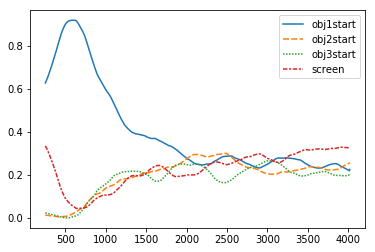

In [12]:
sns.lineplot(data = b[objlist])

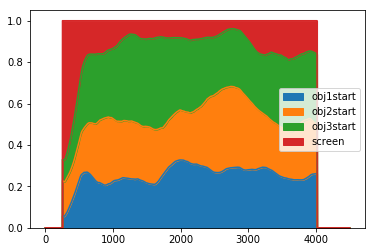

In [44]:
c = actstudyprops.rolling(window=250).mean()
c[objlist].plot.area()

In [45]:
actdif = b-c

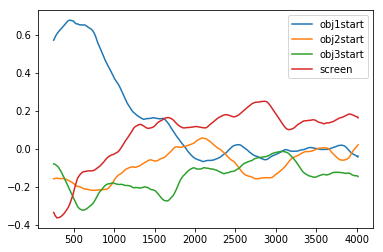

In [46]:
actdif[objlist].plot()

In [20]:
b.reset_index(inplace=True)
b.rename(columns={'index':'time'}, inplace=True)
b

,time,total_fix,obj1start,obj2start,obj3start,screen
0,0,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN
7,7,NaN,NaN,NaN,NaN,NaN
8,8,NaN,NaN,NaN,NaN,NaN
9,9,NaN,NaN,NaN,NaN,NaN
